In [16]:
# created by Yuang Tong at 2021.6.10
import pandas as pd
import numpy as np
import cudf
from RdKit_tools import calc_fingerprints,calc_similarity_matrix,calc_fingerprints_multi_threads

from tqdm import tqdm
import random
import time

import matplotlib.pyplot as plt

import os
from sklearn.manifold import TSNE

In [32]:
COL_NAMES=['UID','UNIPROT_ID','COMPOUND_SMILES','PROTEIN_SEQUENCE','CLF_LABEL','Data_Source']
PRT_ROOT = '/gxr/tongyuang/data/CPI/GLX4.1.0/sub_data/Glx_Pubchem_Uniprot_Classification_Data_79980610_proteins/'
DATA_ROOT = '/gxr/tongyuang/data/CPI/GLX4.1.0/sub_data/Glx4.1.0_clf_Pubchem_Uniprot_Classification_Data_79980610/'
SQS_IDX_DICT_ROOT = '/gxr/tongyuang/data/CPI/GLX4.1.0/sub_data/Glx_Pubchem_Uniprot_Classification_Data_79980610_proteins/sequence_idx_dict.npy'
sqs_idx_dict = np.load(SQS_IDX_DICT_ROOT,allow_pickle=True).item()

In [7]:
output_file_name = './sequence_statistics.csv'
output_df = pd.read_csv(output_file_name)


In [8]:
output_df.head()

,sequence,idx,length,num_pos_lbl,num_neg_lbl,pos_percent,sim_mean,sim_max,sim_var
0,MKFLLVLVLLVSLQVSACGAAPMNESEFAEWYLSRFFDYQGDRIPM...,2378,6,6,0,1.000000,0.318251,1.000000,0.068758
1,MSARGPAIGIDLGTTYSCVGVFQHGKVEIIANDQGNRTTPSYVAFT...,4117,29,9,20,0.310345,0.276557,0.983871,0.052519
2,MTSTGKDGGAQHAQYVGPYRLEKTLGKGQTGLVKLGVHCVTCQKVA...,939,136,36,100,0.264706,0.134901,1.000000,0.003910
3,MSVTEEDLCHHMKVVVRVRPENTKEKAAGFHKVVHVVDKHILVFDP...,2290,533,520,13,0.975610,0.443117,1.000000,0.016330
4,MEDFVRQCFNPMIVELAEKTMKEYGEDLKIETNKFAAICTHLEVCF...,7515,91,10,81,0.109890,0.208731,1.000000,0.023870


In [17]:
subdf = output_df[output_df['sim_max']>-1]
subdf = subdf[subdf['length']>1]

In [18]:
sim_mean = subdf['sim_mean'].values
len(sim_mean)

6602

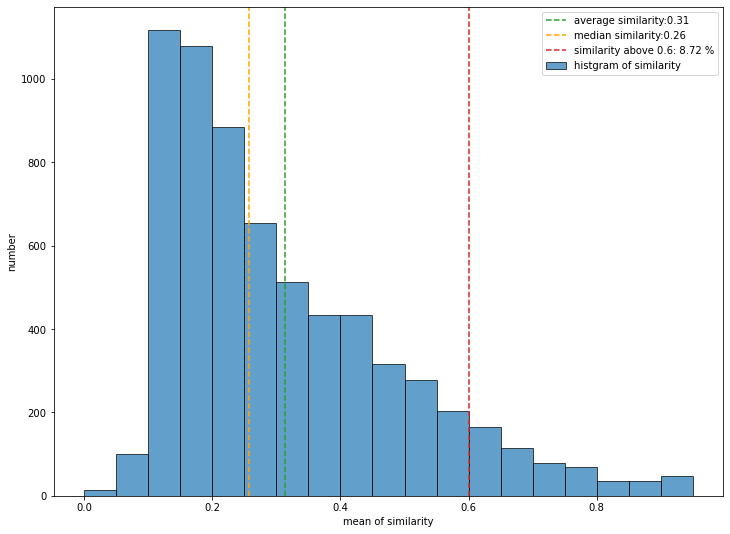

In [91]:
#plt.bar(sim_mean)
import matplotlib.mlab as mlab 

"""
绘制直方图
data:必选参数，绘图数据
bins:直方图的长条形数目，可选项，默认为10
normed:是否将得到的直方图向量归一化，可选项，默认为0，代表不归一化，显示频数。normed=1，表示归一化，显示频率。
facecolor:长条形的颜色
edgecolor:长条形边框的颜色
alpha:透明度
"""
this_bins = np.arange(0,1,0.05)

plt.figure(figsize=(12,9))
plt.hist(sim_mean, bins=this_bins,facecolor="tab:blue", edgecolor="black", alpha=0.7,label='histgram of similarity')

thres = 0.6
ctr = 0
for i in range(sim_mean.shape[0]):
    if (sim_mean[i]>thres):
        ctr += 1

big_pct = ctr/sim_mean.shape[0]


plt.axvline(x=np.mean(sim_mean),color='tab:green',linestyle='--',label='average similarity:{:.2f}'.format(np.mean(sim_mean)))
plt.axvline(x=np.median(sim_mean),color='orange',linestyle='--',label='median similarity:{:.2f}'.format(np.median(sim_mean)))
plt.axvline(x=thres,color='tab:red',linestyle='--',label='similarity above {}: {:.2f} %'.format(thres, big_pct*100))

plt.xlabel("mean of similarity")
plt.ylabel("number")

plt.legend()
plt.show()

## 找几个相似度高的

In [61]:
sim_prt_subdf = subdf[subdf['sim_mean']>0.7]
sim_prt_subdf = sim_prt_subdf[sim_prt_subdf['length']>20]
sim_prt_subdf


,sequence,idx,length,num_pos_lbl,num_neg_lbl,pos_percent,sim_mean,sim_max,sim_var
395,MRDPGAAAPLSSLGLCALVLALLGALSAGAGAQPYHGEKGISVPDH...,5668,37,35,2,0.945946,0.773760,0.990099,0.030478
1460,MQKLQLCVYIYLFMLIVAGPVDLNENSEQKENVEKEGLCNACTWRQ...,398,81,57,24,0.703704,0.754405,1.000000,0.045882
1579,MLRVPLCTPLPLLALLQLLGAAHGIYNVTQRTFKLDYSRDRFLKDG...,1107,23,0,23,0.000000,0.862315,1.000000,0.014988
2050,MDTRNKAQLLVLLTLLSVLFSQTSAWPLYRAPSALRLGDRIPFEGA...,1079,72,62,10,0.861111,0.736080,1.000000,0.140915
2745,METGALRRPQLLPLLLLLCGGCPRAGGCNETGMLERLPLCGKAFAD...,3621,147,145,2,0.986395,0.814538,1.000000,0.026620
2804,MEAIAKYDFKATADDELSFKRGDILKVLNEECDQNWYKAELNGKDG...,7069,27,9,18,0.333333,0.795211,1.000000,0.004962
2873,MGQNNSTPLSLTLDHWKDVRTRAHNLSVKIRKGKWQTFCSSEWPTF...,5653,22,2,20,0.090909,0.762342,1.000000,0.004979
3235,MACWPQLRLLLWKNLTFRRRQTCQLLLEVAWPLFIFLILISVRLSY...,3717,22,22,0,1.000000,0.869387,1.000000,0.005859
3822,MRGGVLLVLLLCVAAQCRQRGLFPAILNLASNAHISTNATCGEKGP...,2668,26,26,0,1.000000,0.879081,1.000000,0.008161
4450,MGLKAAQKTLFPLRSIDDVVRLFAAELGREEPDLVLLSLVLGFVEH...,121,31,30,1,0.967742,0.725269,1.000000,0.028574


In [33]:
def calc_fingerprints_values(fps_in):
    '''
    计算fingerprint 的值
    '''

    fp_values = []

    for fp in fps_in:

        fp_value = [float(i) for i in fp.ToBitString()]

        fp_values.append(fp_value)
    
    return fp_values


def index_to_name(subdata_index):
    '''
    input: int
        0->00
        19->19
    output: str
    '''
    if subdata_index<10:
        return '0'+str(int(subdata_index))
    else:
        return str(int(subdata_index))

def get_smiles_list(sqs_in='',
                    sqs_idx_dict = sqs_idx_dict,
                    prt_root= PRT_ROOT,
                    data_root = DATA_ROOT,
                    col_names = COL_NAMES,
                   suffix='.npy'):
    '''
    get smiles list by sequence

    输入：sequence
    输出：uid和smiles list
    '''

    prt_idx = sqs_idx_dict[sqs_in]
    filename = str(prt_idx)+suffix
    cur_prt_statistics = np.load(prt_root+filename,allow_pickle=True)
    
    subdata_index_list = list(set(cur_prt_statistics[:,0]))
    
    output_smiles_list = []
    uniprot_id = []
    for subdata_index in tqdm(subdata_index_list):
        
        subdata_index = int(subdata_index)
        
        rows = cur_prt_statistics[cur_prt_statistics[:,0]==subdata_index][:,1]
        subdata_name = index_to_name(subdata_index)
        

        if subdata_name=='00':
            cur_df = pd.read_csv(data_root+'part_{}.csv'.format(subdata_name))
        else:
            cur_df = pd.read_csv(data_root+'part_{}.csv'.format(subdata_name),names=col_names)
            
        sub_cur_df = cur_df.iloc[rows]
            
        smiles_list = list(sub_cur_df['COMPOUND_SMILES'].values)

        output_smiles_list += smiles_list

        uniprot_id += list(set(list(sub_cur_df['UNIPROT_ID'].values)))
        
    return uniprot_id,list(set(output_smiles_list))




In [60]:

fp_values_all = []
sim_prt_index_list = list(sim_prt_subdf['idx'].values)

for prt_index in sim_prt_index_list:
    _,cur_smile_list = get_smiles_list(prt_index)
    fp_values = calc_fingerprints_values(calc_fingerprints(cur_smile_list))
    fp_values_all += fp_values

fp_values_array = np.asarray(fp_values_all)
tsne = TSNE(random_state=42)
tsne_fp = tsne.fit_transform(fp_values_array)



100%|██████████| 1/1 [00:04<00:00,  4.96s/it]


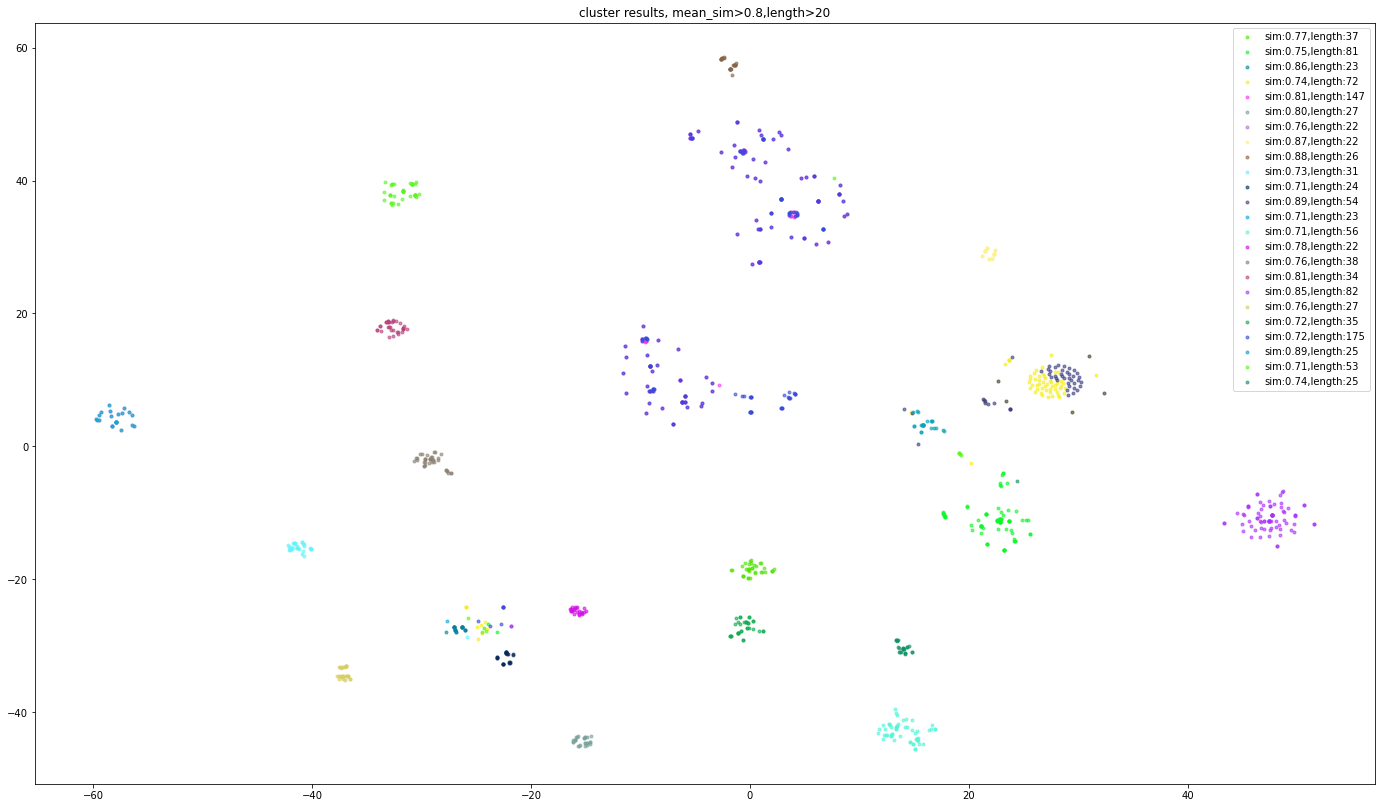

In [80]:
color_dict = {}
for prt_index in sim_prt_index_list:
    color_dict[prt_index] = (random.random(),random.random(),random.random())

prt_lengths = list(sim_prt_subdf['length'].values)
sim_means = list(sim_prt_subdf['sim_mean'].values)
start = 0

plt.figure(figsize=(24,14)) 
for i in range(len(prt_lengths)):

    ll = prt_lengths[i]
    end = start+ll
    X = tsne_fp[start:end,0]
    Y = tsne_fp[start:end,1]

    prt_index = sim_prt_index_list[i]
    plt.scatter(X,Y,color=color_dict[prt_index],alpha=0.6,marker='.',label='sim:{:.2f},length:{}'.format(sim_means[i],ll))

    start = end

plt.title('cluster results, mean_sim>0.8,length>20')
plt.legend()
plt.savefig('./results/cluster.png',dpi=600)
plt.show()


## sequence 长度分析

In [83]:
sequence_list =  list(output_df['sequence'].values)
len_sequence_list = []
for seq in sequence_list:
    len_sequence_list.append(len(seq))

In [94]:
# 手动统计信息
# 分为0-200，200-500，500-1000，1000-2000，2000-5000,5000+
def locate_length(ll,xrange):
    # xrange已经排序好了
    for i in range(1,len(xrange)):
        if ll<xrange[i]:
            return i-1
    return len(xrange)-1

x_range = [0,200,500,1000,2000,5000]
x_bars = []
for i in range(len(x_range)):
    x_bars.append([])

for ll in len_sequence_list:
    try:
        x_bars[locate_length(ll,x_range)].append(ll)
    except:
        print(locate_length(ll,x_range))
        break

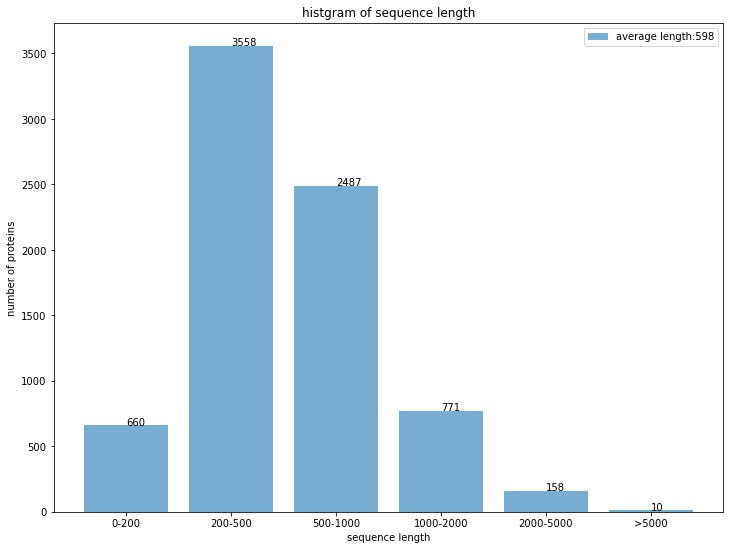

In [108]:
x_lables = []
y_values = []
for i in range(len(x_range)):
    y_values.append(len(x_bars[i]))
    if(i<len(x_range)-1):
        x_lables.append(str(x_range[i])+'-'+str(x_range[i+1]))

x_lables.append('>'+str(x_range[-1]))

x_values = range(len(x_range))

plt.figure(figsize=(12,9))
plt.bar(x_values,y_values,color='tab:blue',alpha=0.6,label='average length:{:d}'.format(int(np.mean(len_sequence_list))))
for x,y in enumerate(y_values):
    plt.text(x,y+2,y_values[x])

plt.xlabel('sequence length')
plt.ylabel('number of proteins')

plt.title('histgram of sequence length')
plt.xticks(x_values,x_lables)
plt.legend()
plt.savefig('./results/histgram_of_sequence_length.png',dpi=600)
plt.show()



In [128]:
long_sequence_list = []
for i in range(len(len_sequence_list)):
    if len_sequence_list[i]>5000:
        long_sequence_list.append(sequence_list[i])


long_protein_df_columns = ['UNIPROT_ID','SEQUENCE','SEQUENCE_LENGTH','DATA_LENGTH']
long_protein_dataframe = pd.DataFrame(columns=long_protein_df_columns)

sqs_idx_dict = np.load(SQS_IDX_DICT_ROOT,allow_pickle=True).item()
for i,long_sqs in enumerate(long_sequence_list):
    #break
    cur_idx = sqs_idx_dict[long_sqs]
    uid,smiles_list = get_smiles_list(cur_idx)
    sequence_length = len(long_sqs)
    data_length = len(smiles_list)

    long_protein_dataframe.loc[i] = {'UNIPROT_ID':uid[0],'SEQUENCE':long_sqs,'SEQUENCE_LENGTH':sequence_length,'DATA_LENGTH':data_length}



100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


In [132]:
long_protein_dataframe.to_csv('long_sequence.csv',index=0)

In [12]:
#subdf = output_df[output_df['pos_percent']<0.3]
#subdf = subdf[subdf['num_pos_lbl']>=7]
#print(len(output_df))
print(np.sum(output_df['length'].values))

79980610


79891350


In [45]:
subdf = output_df[output_df['sim_mean']>0.6]
#subdf = subdf[subdf['sim_mean']<1]
subdf = subdf[subdf['length']>5]
print(len(subdf))

253


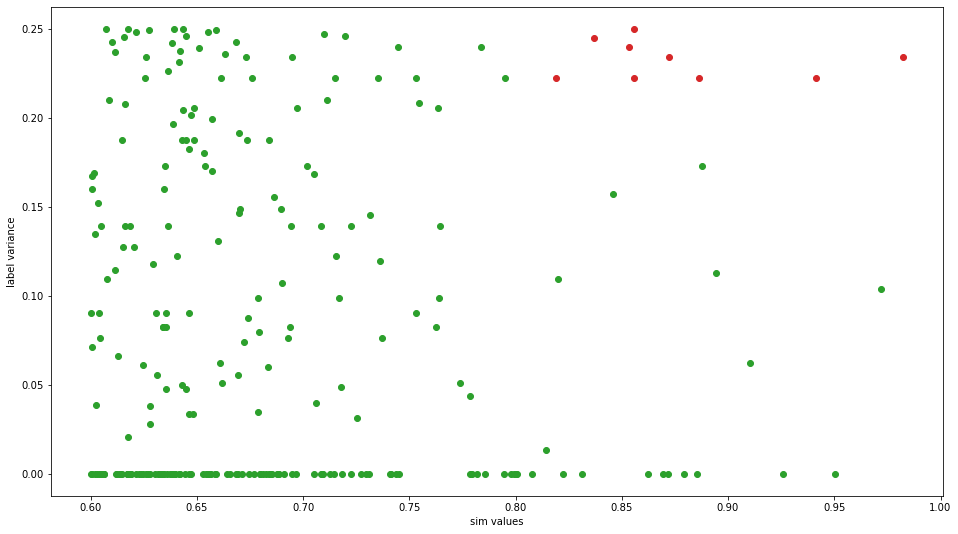

In [38]:
X = subdf['sim_mean'].values
pos_X = subdf['num_pos_lbl'].values
neg_X = subdf['num_neg_lbl'].values
pos_pct_X = subdf['pos_percent'].values

Y = ((1-pos_pct_X)*(1-pos_pct_X)*pos_X+neg_X*pos_pct_X*pos_pct_X)/(pos_X+neg_X)


plt.figure(figsize=(16,9))
#print(X.shape[0])

#plt.scatter(X,Y,marker='o')
row_idxs = []
for i in range(X.shape[0]):
    xx = X[i]
    yy = Y[i]


    if(xx>0.8 and yy>0.2):
        cc = 'tab:red'
        row_idxs.append(i)
    else:
        cc = 'tab:green'
    
    plt.plot(xx,yy,marker='o',color=cc)

plt.xlabel('sim values')
plt.ylabel('label variance')
plt.show()


In [18]:
output_df.columns

Index(['sequence', 'idx', 'length', 'num_pos_lbl', 'num_neg_lbl',
       'pos_percent', 'sim_mean', 'sim_max', 'sim_var'],
      dtype='object')

In [39]:
row_idxs

[28, 106, 110, 123, 135, 174, 184, 188, 211]

In [44]:
subdf.iloc[row_idxs]

,sequence,idx,length,num_pos_lbl,num_neg_lbl,pos_percent,sim_mean,sim_max,sim_var
1079,MAKKKFSGLEISLIVLFIIVTIIAIALVVVLATKVPAVEEVKSPTS...,4706,15,9,6,0.600000,0.853343,1.000000,0.018031
3168,MTILFLTMVISYFGCMKAAPMKEANIRGQGGLAYPGVRTHGTLESV...,104,6,3,3,0.500000,0.855956,1.000000,0.005588
3252,WLIVVVGVMSTMYAKIDPSLGVIAKINRTLDATGYLSSRTQNVVSG...,1692,9,6,3,0.666667,0.886419,1.000000,0.021690
3704,MQAQQYQQQRRKFAAAFLAFIFILAAVDTAEAGKKEKPEKKVKKSD...,5805,6,2,4,0.333333,0.855956,1.000000,0.005588
4028,MAPACLLAPLLLLLLGGFPLVPGESIRETEVIDPQDLLEGRYFSGA...,2608,8,3,5,0.375000,0.982249,1.000000,0.000567
5158,MVLPRLYTATSRAAFKAAKQSAPLLSTSWKRCMASAAQSTPITGKV...,3968,9,6,3,0.666667,0.819252,0.946429,0.004805
5530,MEYHPDLENLDEDGYTQLHFDSQSNTRIAVVSEKGSCAASPPWRLI...,1084,6,2,4,0.333333,0.941463,1.000000,0.002284
5622,MTLESMMACCLSDEVKESKRINAEIEKQLRRDKRDARRELKLLLLG...,197,7,3,4,0.428571,0.837095,1.000000,0.005195
6469,MTLPGHPTGMARPRGAGPCSPGLERAPRRSVGELRLLFEARCAAVA...,3784,8,3,5,0.375000,0.872264,1.000000,0.008185


In [54]:
def euro_dis(x1,x2):
    '''
    欧氏距离
    '''
    assert x1.shape==x2.shape

    return np.sqrt(np.sum(np.square(x1-x2)))

def cal_euro_dis(x,tsne_fps_in):
    '''
    计算欧氏距离，输入是 x =（k,），tsne_fps_in=(n,k)

    输出是(n,1)

    '''
    assert x.shape[0] == tsne_fps_in.shape[1]

    return [euro_dis(x,x_i) for x_i in tsne_fps_in]

def calc_euro_dis_matrix(tsne_fps_in):
    '''
    计算欧氏距离矩阵，输入形状是（n,k），输出形状是（n,n)
    n是样本量
    k是距离

    '''
    return [cal_euro_dis(x,tsne_fps_in) for x in tsne_fps_in]

def calc_mean_euro_dis(smiles_list_in,k=2,multi_thread=False):

    '''
    计算平均欧氏距离
    输入是smiles list，使用fp特征
    输出降维特征的平均欧氏距离
    '''

    if multi_thread:
        fps = calc_fingerprints_multi_threads(smiles_list_in) # (n,1024)
    else:
        fps = calc_fingerprints(smiles_list_in)
    
    fp_values_array = calc_fingerprints_values(fps)
    tsne = TSNE(random_state=42,n_components=k)
    tsne_fp = tsne.fit_transform(fp_values_array) #(n,2)

    print('haha')
    euro_dis_mat = np.asarray(calc_euro_dis_matrix(tsne_fp)) #(n,n)

    
    mean_dis = np.mean(euro_dis_mat[np.triu_indices(euro_dis_mat.shape[0],1)])

    return mean_dis


In [55]:
import time
subdf = output_df[output_df['length'] == 96778]

test_sqs = subdf['sequence'].values[0]

tic = time.time()

_,test_smiles_list = get_smiles_list(test_sqs)
mean_dis = calc_mean_euro_dis(test_smiles_list,k=2)

toc = time.time()

print('num compounds:{},mean distance:{:.2f},time cost:{:.2f} s'.format(len(test_smiles_list),mean_dis,toc-tic))



100%|██████████| 4/4 [00:21<00:00,  5.33s/it]


KeyboardInterrupt: 

In [29]:
a = np.arange(9).reshape((3,3))

a[np.triu_indices(3,1)]

array([1, 2, 5])

In [52]:
output_df[output_df['length']>=10000]


,sequence,idx,length,num_pos_lbl,num_neg_lbl,pos_percent,sim_mean,sim_max,sim_var
15,MANLGCWMLVLFVATWSDLGLCKKRPKPGGWNTGGSRYPGQGSPGG...,2314,369712,979,368733,0.002648,0.136412,0.824561,0.002112
22,MGSLYSEYLNPNKVQEHYNYTKETLETQETTSRQVASAFIVILCCA...,406,96778,193,96585,0.001994,0.136709,0.851064,0.002234
88,MELRPWLLWVVAATGTLVLLAADAQGQKVFTNTWAVRIPGGPAVAN...,482,220814,584,220230,0.002645,0.136405,0.745455,0.002186
94,MVDQLRERTTMADPLRERTELLLADYLGYCAREPGTPEPAPSTPEA...,4557,194130,24,194106,0.000124,0.135310,0.833333,0.002207
167,MSGSFELSVQDLNDLLSDGSGCYSLPSQPCNEVTPRIYVGNASVAQ...,3144,333750,1838,331912,0.005507,0.137368,0.816327,0.002274
...,...,...,...,...,...,...,...,...,...
7493,MALSQSVPFSATELLLASAIFCLVFWVLKGLRPRVPKGLKSPPEPW...,944,17421,6612,10809,0.379542,0.120242,1.000000,0.002471
7569,MTDCEFGYIYRLAQDYLQCVLQIPQPGSGPSKTSRVLQNVAFSVQK...,2744,194238,157,194081,0.000808,0.135442,0.844828,0.002151
7575,MGRYRIRVATGAWLFSGSYNRVQLWLVGTRGEAELELQLRPARGEE...,1777,149463,247,149216,0.001653,0.130949,0.839286,0.002259
7612,MVNSTHRGMHTSLHLWNRSSYRLHSNASESLGKGYSDGGCYEQLFV...,5679,362901,7060,355841,0.019454,0.136919,1.000000,0.002128
